# Synthetic Data Generation

Generate synthetic data with the generators listed below
Based on the Wisconsin Breast Cancer Dataset (WBCD)

In [1]:
# Standard library
import sys

sys.path.append("..")

# 3rd party packages
import pandas as pd

# Local packages
import config
from generators.ctabgan_generator import CTABGANGenerator
from generators.ctgan_generator import CTGANGenerator
from generators.dataSynthesizer import DataSynthesizerGenerator
from generators.mst_generator import MSTGenerator
from generators.smote import SmoteGenerator
from generators.synthpop_generator import SynthpopGenerator
from generators.tabddpm_generator import TabDDPMGenerator
from generators.tvae_generator import TVAEGenerator

## Load the real WBCD training dataset

In [2]:
df_real = pd.read_csv("../data/" + config.WBCD_DATASET_TRAIN_FILEPATH.stem + ".csv")
df_real.shape

(359, 10)

In [3]:
df_real.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,10,10,10,3,10,10,9,10,1,1
1,5,1,2,1,2,1,1,1,1,0
2,6,10,2,8,10,2,7,8,10,1
3,4,8,6,4,3,4,10,6,1,1
4,7,4,7,4,3,7,7,6,1,1


## Create the metadata dictionary

### The continuous and categorical variables need to be specified, as well as the variable to predict for the future learning task (used by SMOTE)

In [4]:
metadata = {
    "continuous": [
        "Clump_Thickness",
        "Uniformity_of_Cell_Size",
        "Uniformity_of_Cell_Shape",
        "Marginal_Adhesion",
        "Single_Epithelial_Cell_Size",
        "Bland_Chromatin",
        "Normal_Nucleoli",
        "Mitoses",
        "Bare_Nuclei",
    ],
    "categorical": ["Class"],
    "variable_to_predict": "Class",
}

## Choose the generator

In [5]:
generator = "synthpop"  # to choose among this list: ["synthpop", "smote", "datasynthesizer", "mst", "ctgan", "tvae", "ctabgan", "tabDDPM"]

### Synthpop

In [6]:
if generator == "synthpop":
    gen = SynthpopGenerator(
        df=df_real,
        metadata=metadata,
        random_state=66,  # for reproducibility, can be set to None
        generator_filepath=None,  # to load an existing generator,
        variables_order=None,  # use the dataframe columns order by default
    )

### SMOTE

In [7]:
if generator == "smote":
    gen = SmoteGenerator(
        df=df_real,
        metadata=metadata,
        random_state=66,  # for reproducibility, can be set to None
        generator_filepath=None,  # to load an existing generator,
        k_neighbors=None,  # cannot be found by searching the best hyperparameters yet, set to 5 by default
    )

### Datasynthesizer

In [8]:
if generator == "datasynthesizer":
    gen = DataSynthesizerGenerator(
        df=df_real,
        metadata=metadata,
        random_state=66,  # for reproducibility, can be set to None
        generator_filepath=None,  # to load an existing generator
        candidate_keys=None,  # the identifiers
        epsilon=0,  # for the differential privacy
        degree=2,  # the maximal number of parents for the bayesian network
    )

### MST

In [9]:
if generator == "mst":
    gen = MSTGenerator(
        df=df_real,
        metadata=metadata,
        random_state=66,  # for reproducibility, can be set to None
        generator_filepath=None,  # to load an existing generator
        epsilon=1.0,  # the privacy budget of the differential privacy
        delta=1e-9,  # the failure probability of the differential privacy
    )

### CTGAN

In [10]:
if generator == "ctgan":
    gen = CTGANGenerator(
        df=df_real,
        metadata=metadata,
        random_state=66,  # for reproducibility, can be set to None
        generator_filepath=None,  # to load an existing generator
        discriminator_steps=4,  # the number of discriminator updates to do for each generator update
        epochs=300,  # the number of training epochs
        batch_size=100,  # the batch size for training
    )

### TVAE

In [11]:
if generator == "tvae":
    gen = TVAEGenerator(
        df=df_real,
        metadata=metadata,
        random_state=66,  # for reproducibility, can be set to None
        generator_filepath=None,  # to load an existing generator
        epochs=300,  # the number of training epochs
        batch_size=100,  # the batch size for training
        compress_dims=(249, 249),  # the size of the hidden layers in the encoder
        decompress_dims=(249, 249),  # the size of the hidden layers in the decoder
    )

### CTAB-GAN+

In [12]:
if generator == "ctabgan":
    gen = CTABGANGenerator(
        df=df_real,
        metadata=metadata,
        random_state=66,  # for reproducibility, can be set to None
        generator_filepath=None,  # to load an existing generator
        mixed_columns=None,  # dictionary of "mixed" column names with corresponding categorical modes
        log_columns=None,  # list of skewed exponential numerical columns
        integer_columns=metadata[
            "continuous"
        ],  # list of numeric columns without floating numbers
        class_dim=(
            256,
            256,
            256,
            256,
        ),  # size of each desired linear layer for the auxiliary classifier
        random_dim=100,  # dimension of the noise vector fed to the generator
        num_channels=64,  # number of channels in the convolutional layers of both the generator and the discriminator
        l2scale=1e-5,  # rate of weight decay used in the optimizer of the generator, discriminator and auxiliary classifier
        batch_size=150,  # batch size for training
        epochs=500,  # number of training epochs
    )

### TabDDPM

In [13]:
if generator == "tabDDPM":
    gen = TabDDPMGenerator(
        df=df_real,
        metadata=metadata,
        random_state=66,  # for reproducibility, can be set to None
        generator_filepath=None,  # to load an existing generator
        learning_rate=1e-5,  # the learning rate for training
        batch_size=256,  # the batch size for training and sampling
        num_timesteps=100,  # the diffusion timesteps for the forward diffusion process
        num_iter=1000,  # the training iterations
        layers=None,  # the width of the MLP layers
    )

## Fit the generator to the real data

In [14]:
gen.preprocess()
gen.fit(save_path="../results/generators")  # the path should exist

## Display the fitted generator

In [15]:
gen.display()

Constructed sequential trees:
   Clump_Thickness has parents []
   Uniformity_of_Cell_Size has parents ['Clump_Thickness']
   Uniformity_of_Cell_Shape has parents ['Clump_Thickness', 'Uniformity_of_Cell_Size']
   Marginal_Adhesion has parents ['Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape']
   Single_Epithelial_Cell_Size has parents ['Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion']
   Bare_Nuclei has parents ['Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size']
   Bland_Chromatin has parents ['Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei']
   Normal_Nucleoli has parents ['Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin']
   Mitoses has parents [

## Generate the synthetic data

In [16]:
df_synth = gen.sample(
    save_path="../results/data",  # the path should exist
    num_samples=len(
        df_real
    ),  # can be different from the real data, but for computing the utility metrics should be the same
)

In [17]:
df_synth.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,8,3,4,3,6,10,3,1,1,1
1,3,1,1,3,2,1,1,1,1,0
2,5,1,1,1,2,1,3,1,1,0
3,10,7,5,6,3,5,3,3,1,1
4,2,7,10,10,7,9,7,10,3,1


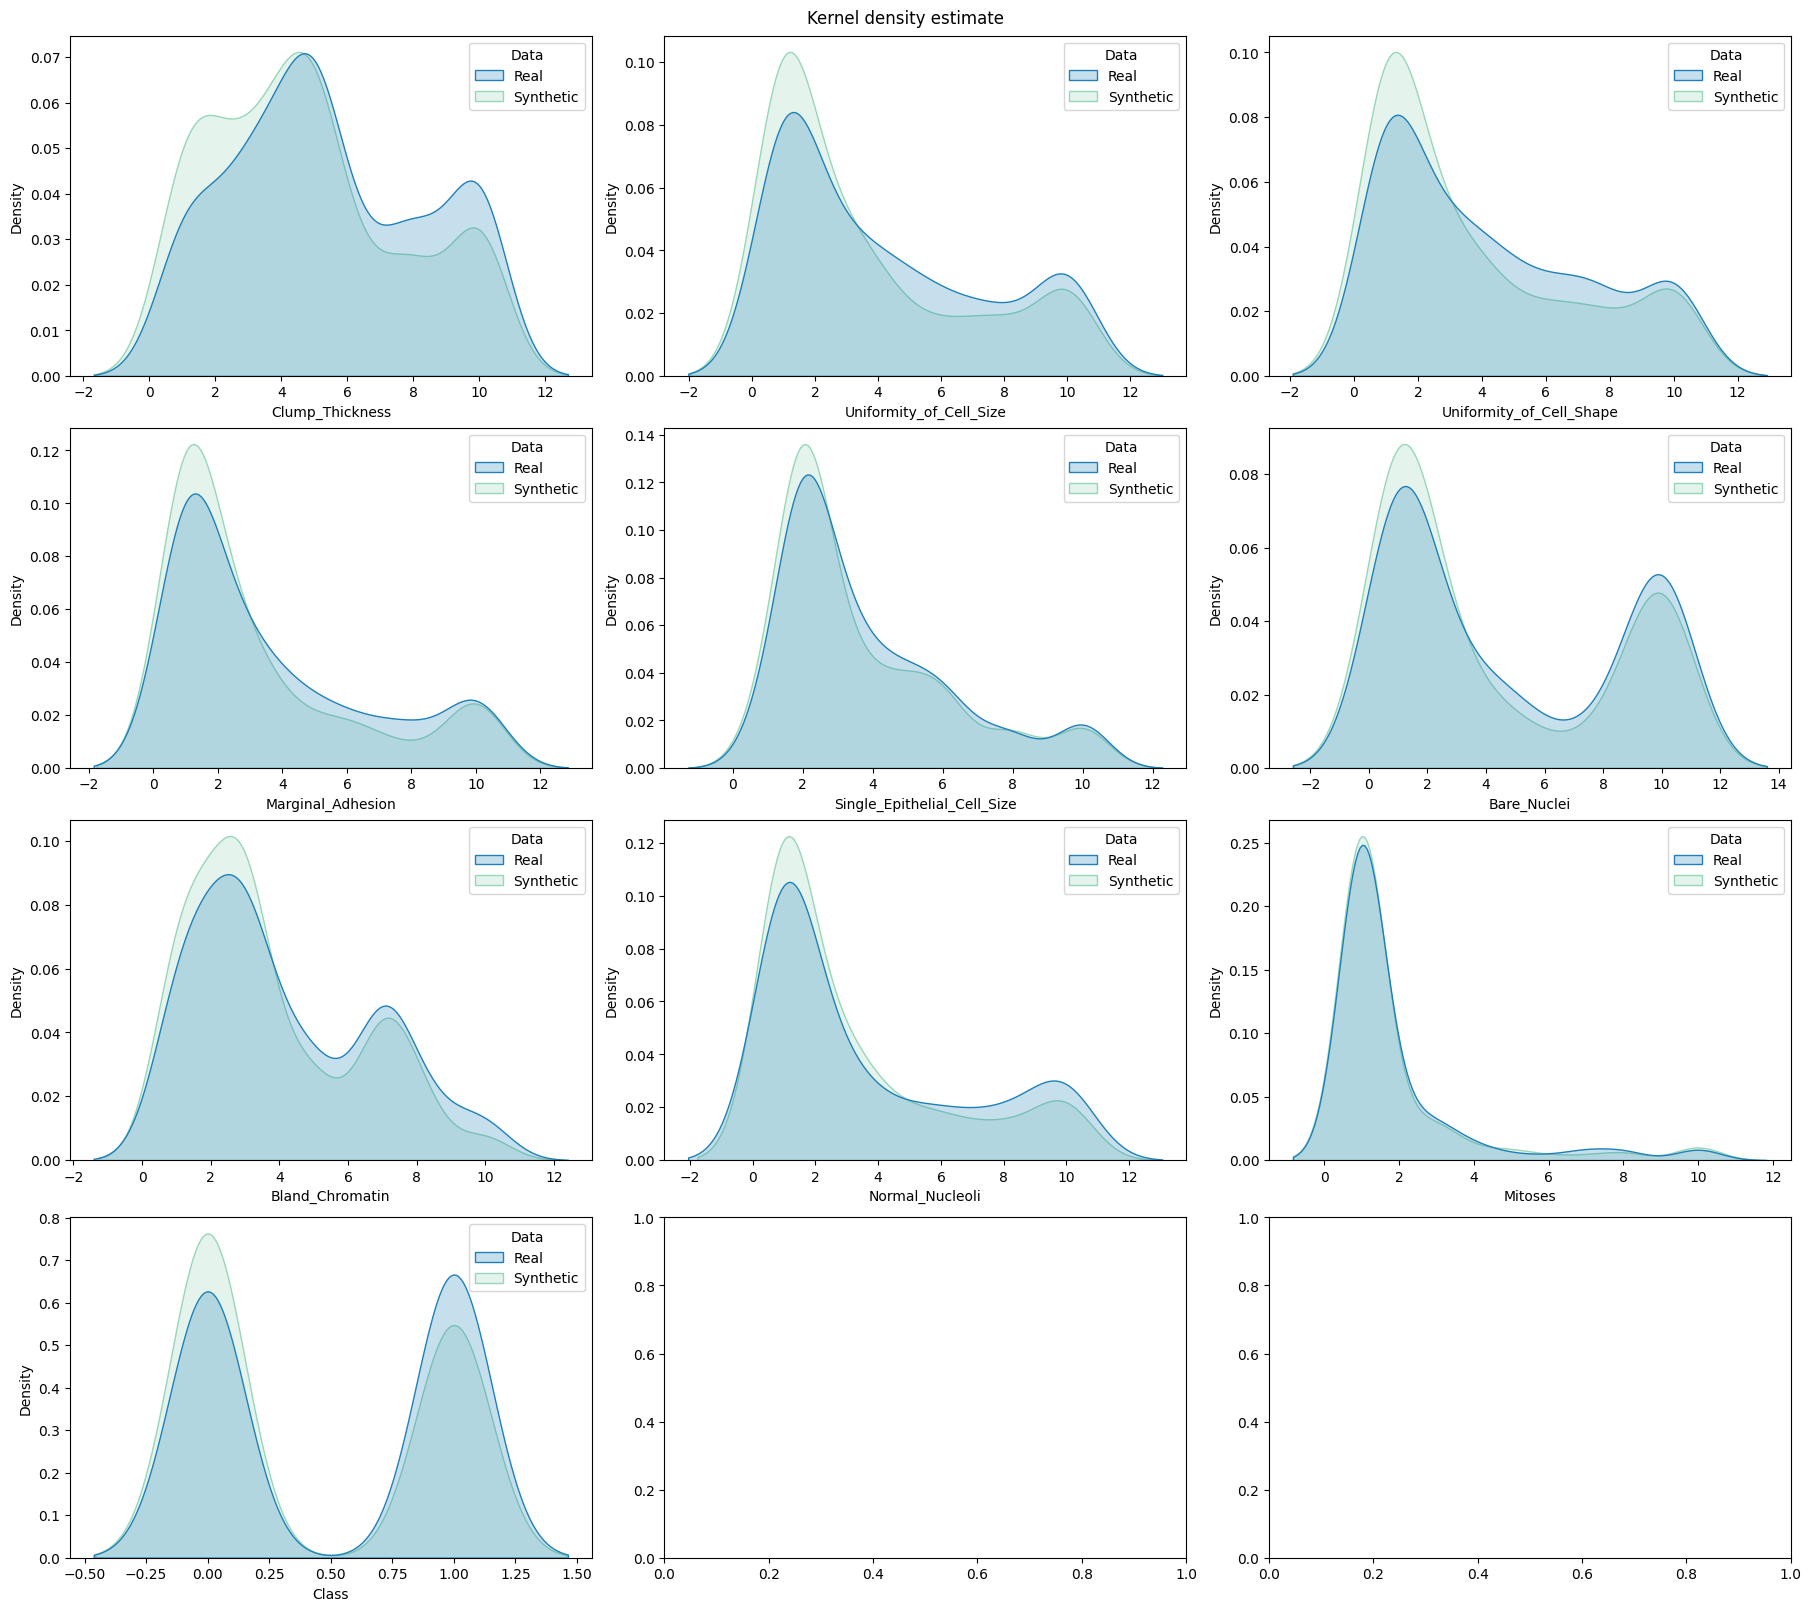

In [18]:
import matplotlib.pyplot as plt

import utils.draw

fig, axes = plt.subplots(  # manually set number of cols/rows
    nrows=4, ncols=3, squeeze=0, figsize=(18, 16), layout="constrained"
)
axes = axes.reshape(-1)
utils.draw.kde_plot_hue_plot_per_col(
    df=df_real,
    df_nested=df_synth,
    original_name="Real",
    nested_name="Synthetic",
    hue_name="Data",
    title="Kernel density estimate",
    axes=axes,
)